## Agent with and Memory 


https://github.com/langchain-ai/langchain-academy

### Module Import and Auto-Reload

In [1]:
# Make sure autoreload is properly set up for auto reload the module if changes
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
from dotenv import load_dotenv, find_dotenv

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)


_ = load_dotenv(find_dotenv())

# print(os.environ.get('OPENAI_API_KEY'))

### Phoenix for tracing LLM

In [ ]:
# from phoenix.otel import register

# os.environ['PHOENIX_COLLECTOR_ENDPOINT'] = "http://localhost:6006"

# trace_provider =  register(
#     project_name="AgentWithToolsAndMemory",
#     auto_instrument=True

# )

<!-- Username
Vehicle registration
Vehicle Make
Vehicle Model
Vehicle colour
Email address
Full ID/Passport number (Can be confirmed on its own)

--Date of birth
--VIN Number
--Residential Address
--Contact Number -->


### Agent Loading

When we use memory, we need to specify a `thread_id`.

This `thread_id` will store our collection of graph states.

Here is a cartoon:

* The checkpointer write the state at every step of the graph
* These checkpoints are saved in a thread 
* We can access that thread in the future using the `thread_id`

![state.jpg](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e0e9f526b41a4ed9e2d28b_agent-memory2.png)


In [3]:
from app_config import CONFIG
from src.Agents.agent00_basic_agent import BasicAgent, BasicAgentState
from src.Agents import DEFAULT_TOOLS
from langchain_ollama import ChatOllama

# Create a new instance with with thread for persist memmory
config = CONFIG.copy()
config["configurable"]={"thread_id": 1}
config['configurable']['use_memory'] = True
config['configurable']['enable_stt_model'] = False
config['configurable']['enable_tts_model'] = False

system_prompt = "You are AI helpful assistant"
def pre_processing_node(state:BasicAgentState):
    messages = state.get('messages',[]) # + [SystemMessage("Please reponse in Vietnamese only")]
    return {"messages":messages}


def post_processing_node(state:BasicAgentState):
    messages = state.get('messages',[])
    return {"messages":messages}
llm = ChatOllama(model="qwen2.5:7b-instruct", temperature=0, num_ctx=8192)
agent = BasicAgent(
                model=llm, 
                system_prompt=system_prompt,
                tools = DEFAULT_TOOLS,
                pre_processing_node=pre_processing_node,
                post_processing_node=post_processing_node,
                config=config,
                )
graph = agent.workflow


2025-04-18 22:57:01,066 - INFO - Workflow graph built successfully
2025-04-18 22:57:01,066 - INFO - Initializing EnhancedToolAgent:
2025-04-18 22:57:01,067 - INFO -   - Tools: 5
2025-04-18 22:57:01,067 - INFO -   - Context window size: 8
2025-04-18 22:57:01,067 - INFO -   - Memory persistence: InMemorySaver
2025-04-18 22:57:01,067 - INFO -   - Pre-processing: pre_processing_node
2025-04-18 22:57:01,068 - INFO -   - Post-processing: post_processing_node
2025-04-18 22:57:01,068 - INFO -   - System prompt: 'You are AI helpful assistant'


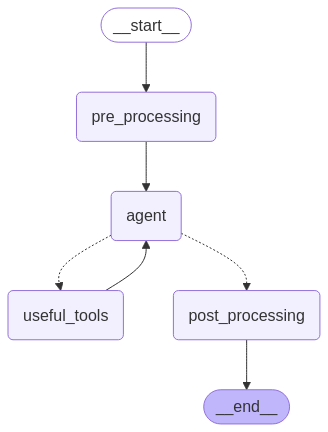

In [4]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles


# display(Image(agent.workflow.get_graph().draw_mermaid_png()))
# print(agent.workflow.get_graph().draw_mermaid())
display(

    Image(
        agent.workflow.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    
)

In [14]:
# agent.set_logging(False)
# agent.set_debug_mode(True)


# config["configurable"]= {"thread_id": 2}
# agent.config = config

# agent.process_message("what is temperature of hochiminh city")

response = agent.invoke("hello",thread_id="2")["messages"]

for msg in response:
    msg.pretty_print()



2025-04-18 22:59:55,346 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! How can I assist you today?
================================ Human Message =================================

hello
================================== Ai Message ==================================

Hello! Is there a specific question or task you need help with?


In [15]:
config["configurable"]= {"thread_id": 1}

agent.config = config
print(agent.invoke("I am Trung", thread_id='5')['messages'][-1].content)

print(agent.invoke("what is my name", thread_id='5')['messages'][-1].content)



2025-04-18 23:00:50,013 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Nice to meet you, Trung! How can I assist you today? Do you have a question or need help with something specific?


2025-04-18 23:00:50,241 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Your name is Trung. Is there anything else you would like to know or discuss?


In [16]:
# Use your agent with persistence
response = agent.invoke("I am Trung", thread_id="weather-thread-1")
print(response["messages"][-1].content)

# Continue the conversation in the same thread
follow_up = agent.invoke("How about in New York?", thread_id="weather-thread-1")
print(follow_up["messages"][-1].content)

# Stream responses
i=0
for step in agent.stream("tell me 2^2", thread_id="weather-thread-2"):
    i += 1
    print(f"{i}:{step['messages'][-1].content}")

2025-04-18 23:23:37,230 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Nice to meet you, Trung! How can I assist you today? Do you have a question or need help with something specific?


2025-04-18 23:23:37,636 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


Sure! Could you please provide more details about what you'd like to know about New York? Are you looking for information on attractions, weather, events, or perhaps something else?
1:tell me 2^2
2:tell me 2^2


2025-04-18 23:23:37,871 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
2025-04-18 23:23:38,061 - INFO - HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


3:
4:4
5:The result of \(2^2\) is 4.
6:The result of \(2^2\) is 4.


In [10]:
print(agent.workflow.get_state(agent.config).values['messages'][-6].content)

what is my name


https://langchain-ai.github.io/langgraph/cloud/how-tos/background_run/

In [ ]:
from langgraph_sdk import get_client
client = get_client(url="http://127.0.0.1:2024")
# Using the graph deployed with the name "agent"
assistant_id = "agent_basic_1"

# create thread
thread = await client.threads.create()
print(thread)

2025-04-18 23:27:30,760 - INFO - HTTP Request: POST http://127.0.0.1:2024/threads "HTTP/1.1 200 OK"


{'thread_id': 'd7a36ee3-1919-4f79-9ebb-5a400a7dc754', 'created_at': '2025-04-18T15:27:30.760500+00:00', 'updated_at': '2025-04-18T15:27:30.760503+00:00', 'metadata': {}, 'status': 'idle', 'config': {}, 'values': None}


In [18]:
runs = await client.runs.list(thread["thread_id"])
print(runs)


2025-04-18 23:26:52,207 - INFO - HTTP Request: GET http://127.0.0.1:2024/threads/fd604a96-92da-46f2-a5d6-67cc4709d6ea/runs?limit=10&offset=0 "HTTP/1.1 200 OK"


[]


In [19]:
input = {"messages": [{"role": "user", "content": "what's the weather in sf"}]}
run = await client.runs.create(thread["thread_id"], assistant_id, input=input)

2025-04-18 23:27:04,378 - INFO - HTTP Request: POST http://127.0.0.1:2024/threads/fd604a96-92da-46f2-a5d6-67cc4709d6ea/runs "HTTP/1.1 200 OK"
